In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# Function to generate synthetic data for a linear model
# w: Tensor representing the true weight vector of the model
# b: Scalar bias term
# num_examples: Number of data points (samples) to generate
def synthetic_data(w, b, num_examples):
    """
    Generates synthetic data based on a linear model with Gaussian noise.

    Parameters:
    w (torch.Tensor): A weight vector of shape (d,), where d is the number of features.
    b (float or torch.Tensor): A scalar bias term.
    num_examples (int): Number of data points to generate.

    Returns:
    X (torch.Tensor): Feature matrix of shape (num_examples, len(w)), 
                      where each row is a sample with values drawn from a normal distribution.
    y (torch.Tensor): Target vector of shape (num_examples, 1), computed as a linear combination of X and w with bias b 
                      and additional Gaussian noise.
    """

    # X is created with shape (num_examples, len(w)), meaning it has `num_examples` rows and `len(w)` columns.
    # Each value in X is drawn from a normal distribution (Gaussian) with mean 0 and standard deviation 1.
    X = torch.normal(0, 1, (num_examples, len(w))) 

    # Compute the target variable y using the linear model y = Xw + b
    # `torch.matmul(X, w)` performs matrix multiplication between X (num_examples, d) and w (d,)
    # This results in a tensor of shape (num_examples,)
    y = torch.matmul(X, w) + b

    # The noise is drawn from a normal distribution with mean 0 and a small standard deviation (0.01)
    # This simulates real-world data where labels are not perfectly linear
    y += torch.normal(0, 0.01, y.shape)

    # Reshape y into a column vector of shape (num_examples, 1)
    # This is necessary to match supervised learning format, where labels are typically column vectors
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape, true_w.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]), torch.Size([2]))

In [3]:
features[:, 1].min(), features[:, 1].max(), labels.min(), labels.max()

(tensor(-4.0362), tensor(3.3246), tensor(-8.6224), tensor(17.7646))

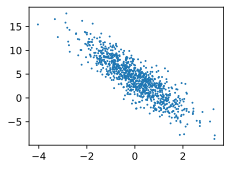

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), 
                labels.detach().numpy(), 1)

In [6]:
def data_iter1(batch_size, features, labels):
    """
    Generates mini-batches from the dataset for stochastic gradient descent (SGD).

    Parameters:
    batch_size (int): The number of samples in each mini-batch.
    features (torch.Tensor): The feature matrix of shape (num_examples, num_features).
    labels (torch.Tensor): The corresponding label vector of shape (num_examples, 1).

    Yields:
    (torch.Tensor, torch.Tensor): A tuple containing a batch of features and labels.
    """

    # Determine the total number of examples in the dataset
    num_examples = len(features)  

    # Create a list of indices to reference the dataset
    indices = list(range(num_examples))  

    # Shuffle the indices randomly to ensure stochasticity in mini-batch selection--this shuffle is for generalizing our dataset, reduce potential overfitting 
    # This helps to prevent the model from overfitting to a specific order of data
    random.shuffle(indices)  

    #  Iterate over the shuffled dataset in mini-batches
    for i in range(0, num_examples, batch_size):
        # Select batch indices within range
        # Ensures that the last batch does not exceed the dataset size
        batch_indices = indices[i: min(i + batch_size, num_examples)]  

        # Convert batch indices into a tensor (if needed)
        # Tensor indexing is preferable for GPU-based computations
        yield features[batch_indices], labels[batch_indices]  # The yield function is to be explained, this function is very important in python

# Define batch size
batch_size = 10

# Iterate through one batch using the data_iter1 function
for X, y in data_iter1(batch_size, features, labels):
    print(X, '\n', y)
    break  # Only print the first batch and exit the loop

tensor([[ 0.9221,  0.6449],
        [ 2.5806, -1.0493],
        [-0.4581, -0.1354],
        [-0.3254, -0.5412],
        [-0.1276, -0.6835],
        [-0.4034, -0.4419],
        [ 2.7689,  1.9449],
        [-0.5466,  0.1786],
        [-0.2445,  0.2551],
        [ 0.4684,  0.1442]]) 
 tensor([[ 3.8465],
        [12.9174],
        [ 3.7605],
        [ 5.3886],
        [ 6.2775],
        [ 4.9093],
        [ 3.1232],
        [ 2.5022],
        [ 2.8629],
        [ 4.6568]])
